In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))



Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [3]:
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json



In [4]:
!kaggle datasets download -d emmarex/plantdisease


Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
plantdisease.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
from zipfile import ZipFile
file_name = "/content/plantdisease.zip" # Changed the file name to the correct one.
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [6]:
import os
import shutil

# Set the path to the dataset directory
dataset_dir = "/content/PlantVillage"

# List all directories in the dataset
directories = [f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))]

# Specify the directories you want to delete (all paths should be relative to dataset_dir)
directories_to_delete = [
    "Pepper__bell___Bacterial_spot",
    "Pepper__bell___healthy",
    "Potato___Early_blight",
    "Potato___healthy",
    "Potato___Late_blight",
]

# Iterate over the directories and delete them along with their contents
for directory in directories_to_delete:
    directory_path = os.path.join(dataset_dir, directory)
    if os.path.exists(directory_path):
        shutil.rmtree(directory_path)
        print(f"Deleted directory: {directory_path}")
    else:
        print(f"Directory not found: {directory_path}")


Deleted directory: /content/PlantVillage/Pepper__bell___Bacterial_spot
Deleted directory: /content/PlantVillage/Pepper__bell___healthy
Deleted directory: /content/PlantVillage/Potato___Early_blight
Deleted directory: /content/PlantVillage/Potato___healthy
Deleted directory: /content/PlantVillage/Potato___Late_blight


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Use tensorflow.keras instead of just keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout, MaxPooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import models, layers
from tensorflow.keras.applications.vgg16 import preprocess_input # Use tensorflow.keras instead of just keras
from tensorflow.keras.preprocessing import image # Use tensorflow.keras instead of just keras
# from keras.preprocessing.image import ImageDataGenerator # No longer needed
from tensorflow.keras.models import Sequential # Use tensorflow.keras instead of just keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import os
import cv2
from tensorflow.keras.utils import load_img, img_to_array # Use tensorflow.keras instead of just keras
import tensorflow as tf


**Directories & Classes**<br>
These are the path of the dataset innter folders and classes in the given dataset

In [8]:
DIRECTORY = r'/content/'
FOLDERS = ['PlantVillage']
CLASSES = ['Tomato_healthy',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato_Septoria_leaf_spot',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_Leaf_Mold',
 'Tomato_Bacterial_spot',
 'Tomato_Late_blight',
 'Tomato_Early_blight',
 'Tomato__Tomato_YellowLeaf__Curl_Virus']


**Load Data**<br>
The given code is loading the training and validation data from the dataset and convert these images to array with the size of 256x256 and append each image datain train_data, and val_data list. I have loaded just 2500 images from eaach class due to limitted resources.


In [9]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS =20

In [10]:
data = []
for folder in FOLDERS:
  folder_path = os.path.join(DIRECTORY, folder)
  for classification in CLASSES:
    image_path = os.path.join(folder_path, classification)
    images = os.listdir(image_path)
    images = images[:500]
    for image in images:
      try:
        image_url = os.path.join(image_path, image)
        arr = cv2.imread(image_url)
        arr = cv2.resize(arr, (IMAGE_SIZE,IMAGE_SIZE))
        label = CLASSES.index(classification)
        data.append([arr, label])
      except Exception as e:
        print("Error : ",e)

Error :  OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [11]:
len(data)

4872

In [12]:
classes_names = CLASSES
print(classes_names)

['Tomato_healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato_Septoria_leaf_spot', 'Tomato__Tomato_mosaic_virus', 'Tomato_Leaf_Mold', 'Tomato_Bacterial_spot', 'Tomato_Late_blight', 'Tomato_Early_blight', 'Tomato__Tomato_YellowLeaf__Curl_Virus']


In [13]:
import random
random.shuffle(data)


**Seperate Dependent & Independent Data**

In [14]:
X = []
y = []
for feature, label in data:
  X.append(feature)
  y.append(label)


In [15]:


X = np.array(X)
y = np.array(y)


In [16]:
X.shape

(4872, 256, 256, 3)

In [17]:
y.shape

(4872,)

In [18]:

from sklearn.model_selection import train_test_split

# Assuming you have your data stored in X and corresponding labels in y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [19]:
len(X_train)

4384

In [20]:
len(y_train)

4384

In [21]:

len(X_test)

488

In [22]:
len(y_test)

488

**Building the Model**<br>
**Creating a Layer for Resizing and Normalization**<br>
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.<br>

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [23]:

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])



**Data Augmentation**<br>
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [24]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])


**Model Architecture**<br>
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks

In [25]:
from tensorflow.keras import layers, models, regularizers
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
     layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 10)                    │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 184,202 (719.54 KB)

 Trainable params: 184,202 (719.54 KB)

 Non-trainable params: 0 (0.00 B)

**Compiling the Model**<br>
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [27]:


model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [35]:

r = model.fit(X_train,y_train, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.8608 - loss: 0.4099 - val_accuracy: 0.7058 - val_loss: 0.9617
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.8568 - loss: 0.3881 - val_accuracy: 0.7127 - val_loss: 1.0192
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - accuracy: 0.8552 - loss: 0.4006 - val_accuracy: 0.7127 - val_loss: 1.0449
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - accuracy: 0.8757 - loss: 0.3777 - val_accuracy: 0.7993 - val_loss: 0.6128
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.8694 - loss: 0.3806 - val_accuracy: 0.7948 - val_loss: 0.6946
Epoch 6/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.8703 - loss: 0.3511 - val_accuracy: 0.8210 - val_loss: 0.5849
Epoch 7/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - accuracy: 0.8828 - loss: 0.3322 - val_accuracy: 0.6933 - val_loss: 1.0202
Epoch 8/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - accuracy: 0.8904 - loss: 0

In [36]:



test_loss, test_accuracy = model.evaluate(X_test, y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9440 - loss: 0.1513


In [37]:


r.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [44]:

r.history["accuracy"]

[0.8528656959533691,
 0.8579983115196228,
 0.854006290435791,
 0.8694040775299072,
 0.8736811876296997,
 0.8696891665458679,
 0.8805246353149414,
 0.8856572508811951,
 0.8865126967430115,
 0.8856572508811951,
 0.8925006985664368,
 0.9033361673355103,
 0.9044767618179321,
 0.8984887599945068,
 0.8910750150680542,
 0.9141716361045837,
 0.9210150837898254,
 0.9130311012268066,
 0.9292842745780945,
 0.9295694231987,
 0.9198745489120483,
 0.9210150837898254,
 0.9210150837898254,
 0.92671799659729,
 0.9232962727546692,
 0.9252922534942627,
 0.9384089112281799,
 0.9341317415237427,
 0.9364128708839417,
 0.9275734424591064]

In [46]:
acc=r.history["accuracy"]
val_acc=r.history["val_accuracy"]

loss=r.history["loss"]
val_loss=r.history["val_loss"]

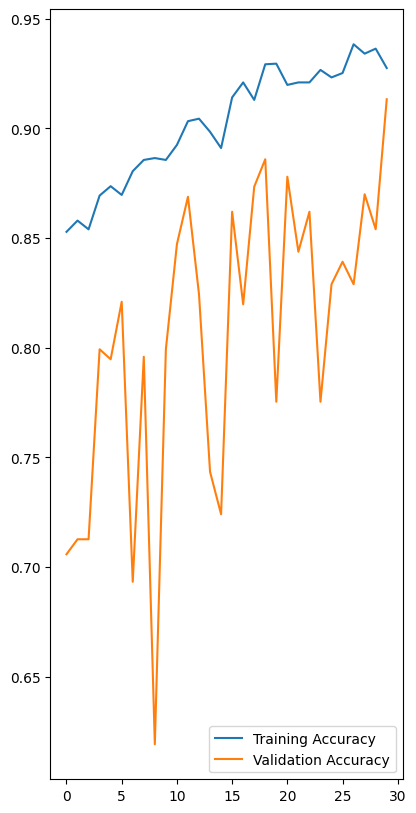

In [47]:
EPOCHS=30
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label="Training Accuracy")
plt.plot(range(EPOCHS),val_acc,label="Validation Accuracy")
plt.legend(loc="lower right")


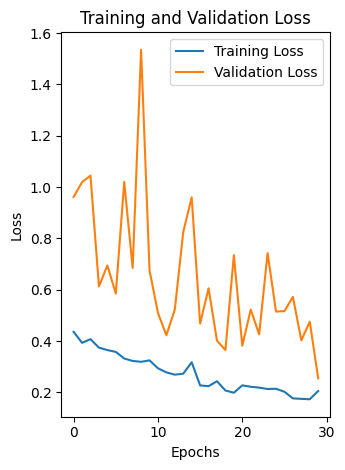

In [48]:


# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


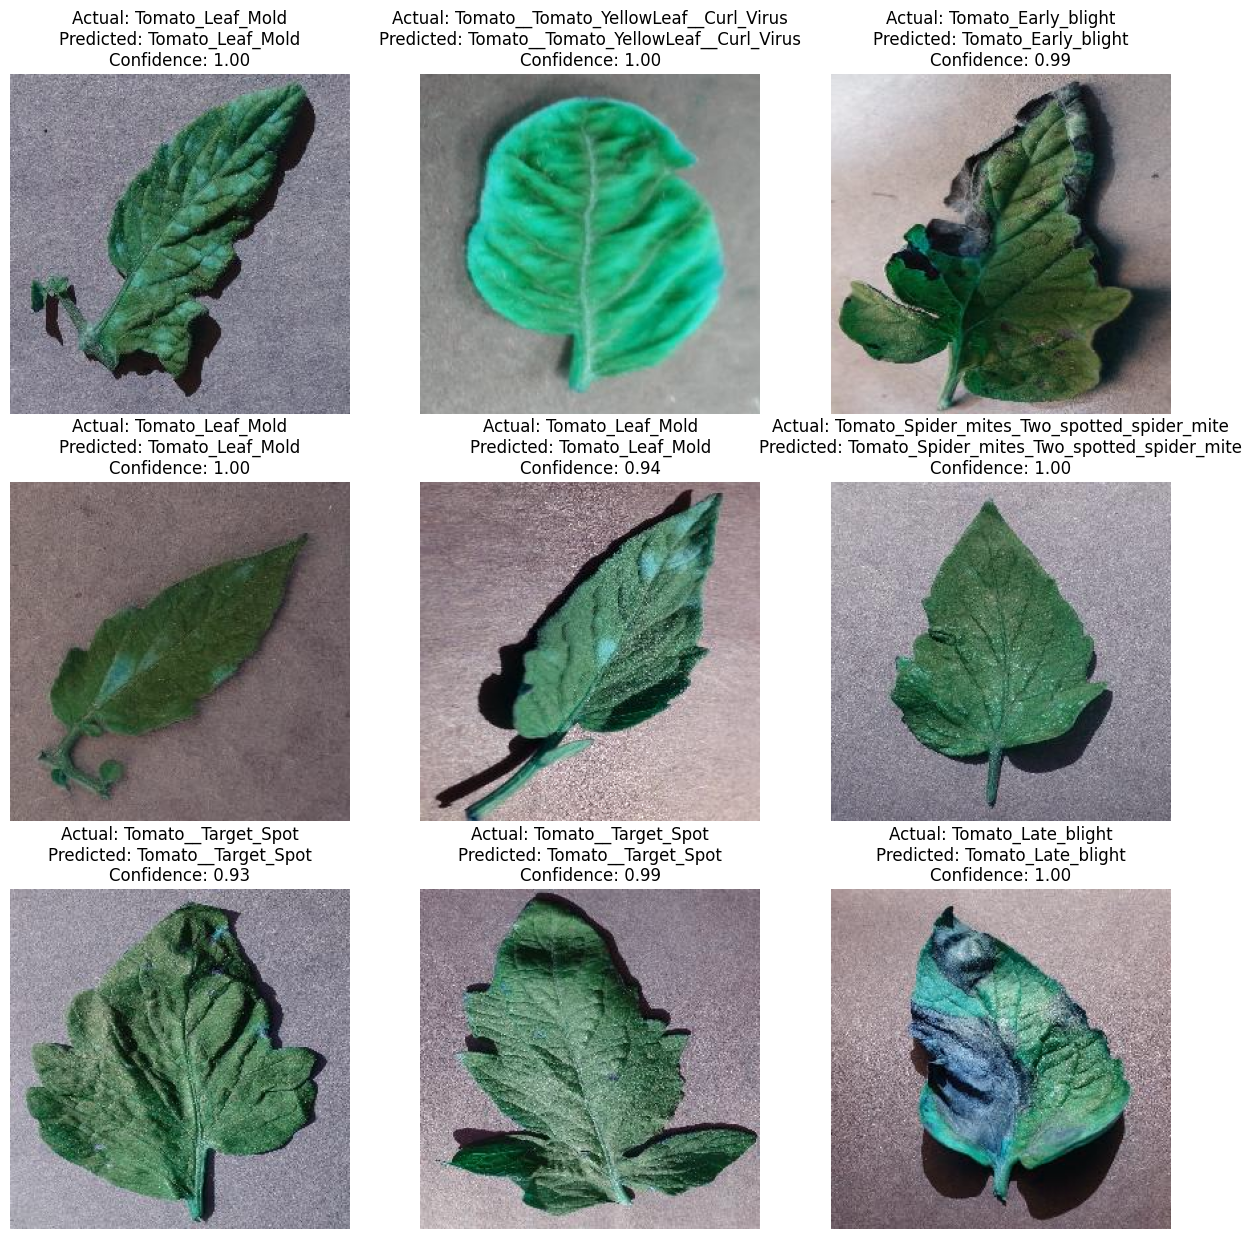

In [49]:


import matplotlib.pyplot as plt

def predict(model, image):
    # Preprocess the image if necessary
    # For example, resizing and scaling if needed
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    prediction = model.predict(image)
    predicted_class_index = tf.argmax(prediction[0]).numpy()
    confidence = tf.reduce_max(prediction[0]).numpy()
    predicted_class = CLASSES[predicted_class_index]
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for index, image in enumerate(X_test):
    if index < 9:
        ax = plt.subplot(3, 3, index + 1)
        plt.imshow(image)
        predicted_class, confidence = predict(model, image)
        label = y_test[index]
        actual_class = CLASSES[label]
        plt.title(f'Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.2f}')
        plt.axis('off')
    else:
        break

plt.show()

In [51]:
from tensorflow.keras.models import save_model

# Save the entire model using the native Keras format
model.save('tomato.keras')